<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
import statistics as st
import datetime
from datetime import datetime 
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import re 
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
nltk.download('punkt')
nltk.download('omw-1.4')
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.dummy import DummyClassifier
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from collections import defaultdict
nltk.download('averaged_perceptron_tagger')
from sklearn.svm import LinearSVC
import numpy
import seaborn
import matplotlib.pyplot as plot
import math
from math import log
from nltk.tokenize import word_tokenize
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ahsun\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ahsun\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ahsun\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Ahsun\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Ahsun\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# Loads a data file from a provided file location.
def load_data(path):

    try:
        loaded_data = pd.read_csv(path)
        print(loaded_data)
    except:
        print('The required file does not exist!')    

    return loaded_data

In [3]:
train_data = load_data("IA3-train.csv")

      sentiment                                               text
0             0  @united who is in charge of making decisions o...
1             0  @united great decision making skills flight op...
2             0  @AmericanAir so what if I didn't have the fund...
3             0  @united My flying United is over...sorry. The ...
4             0  @united I believe just customer service. At la...
...         ...                                                ...
8995          1  @SouthwestAir your flight attendants are reall...
8996          1  @VirginAmerica Love the team running Gate E9 a...
8997          0  @SouthwestAir really shouldn't offer sweeps if...
8998          0  @united no HUMAN contact for 2 mths from @Amer...
8999          1  @JetBlue Landing! As usual great flight wiyh a...

[9000 rows x 2 columns]


In [4]:
val_data = load_data("IA3-dev.csv")

      sentiment                                               text
0             1  @JetBlue Then en route to the airport the rebo...
1             0  @JetBlue I’m going to miss a hugely important ...
2             0  @USAirways never flying you guys again. your c...
3             0  @AmericanAir but, what I can always rely on wh...
4             0  @JetBlue you really should be more proactive w...
...         ...                                                ...
2495          0  @united kind of unnerving to watch the guy dei...
2496          0  @united already did that at the airport and 12...
2497          0  @JetBlue and they are telling me I got to get ...
2498          0  @USAirways delayed 2 days for weather and on t...
2499          0  @SouthwestAir We've been sitting at the gate f...

[2500 rows x 2 columns]


In [5]:
import numpy as np

# Loads GloVe embeddings from a designated file location. 
#
# Invoked via:
# ge = GloVe_Embedder(path_to_embeddings)
#
# Embed single word via:
# embed = ge.embed_str(word)
#
# Embed a list of words via:
# embeds = ge.embed_list(word_list)
#
# Find nearest neighbors via:
# ge.find_k_nearest(word, k)
#
# Save vocabulary to file via:
# ge.save_to_file(path_to_file)

class GloVe_Embedder:
    def __init__(self, path):
        self.embedding_dict = {}
        self.embedding_array = []
        self.unk_emb = 0
        # Adapted from https://stackoverflow.com/questions/37793118/load-pretrained-GloVe-vectors-in-python
        with open(path,'r') as f:
            for line in f:
                split_line = line.split()
                word = split_line[0]
                embedding = np.array(split_line[1:], dtype=np.float64)
                self.embedding_dict[word] = embedding
                self.embedding_array.append(embedding.tolist())
        self.embedding_array = np.array(self.embedding_array)
        self.embedding_dim = len(self.embedding_array[0])
        self.vocab_size = len(self.embedding_array)
        self.unk_emb = np.zeros(self.embedding_dim)

    # Check if the provided embedding is the unknown embedding.
    def is_unk_embed(self, embed):
        return np.sum((embed - self.unk_emb) ** 2) < 1e-7
    
    # Check if the provided string is in the vocabulary.
    def token_in_vocab(self, x):
        if x in self.embedding_dict and not self.is_unk_embed(self.embedding_dict[x]):
            return True
        return False

    # Returns the embedding for a single string and prints a warning if
    # the string is unknown to the vocabulary.
    # 
    # If indicate_unk is set to True, the return type will be a tuple of 
    # (numpy array, bool) with the bool indicating whether the returned 
    # embedding is the unknown embedding.
    #
    # If warn_unk is set to False, the method will no longer print warnings
    # when used on unknown strings.
    def embed_str(self, x, indicate_unk = False, warn_unk = True):
        if self.token_in_vocab(x):
            if indicate_unk:
                return (self.embedding_dict[x], False)
            else:
                return self.embedding_dict[x]
        else:
            if warn_unk:
                    print("Warning: provided word is not part of the vocabulary!")
            if indicate_unk:
                return (self.unk_emb, True)
            else:
                return self.unk_emb

    # Returns an array containing the embeddings of each vocabulary token in the provided list.
    #
    # If include_unk is set to False, the returned list will not include any unknown embeddings.
    def embed_list(self, x, include_unk = True):
        if include_unk:
            embeds = [self.embed_str(word, warn_unk = False).tolist() for word in x]
        else:
            embeds_with_unk = [self.embed_str(word, indicate_unk=True, warn_unk = False) for word in x]
            embeds = [e[0].tolist() for e in embeds_with_unk if not e[1]]
            if len(embeds) == 0:
                print("No known words in input:" + str(x))
                embeds = [self.unk_emb.tolist()]
        return np.array(embeds)
    
    # Finds the vocab words associated with the k nearest embeddings of the provided word. 
    # Can also accept an embedding vector in place of a string word.
    # Return type is a nested list where each entry is a word in the vocab followed by its 
    # distance from whatever word was provided as an argument.
    def find_k_nearest(self, word, k, warn_about_unks = True):
        if type(word) == str:
            word_embedding, is_unk = self.embed_str(word, indicate_unk = True)
        else:
            word_embedding = word
            is_unk = False
        if is_unk and warn_about_unks:
            print("Warning: provided word is not part of the vocabulary!")

        all_distances = np.sum((self.embedding_array - word_embedding) ** 2, axis = 1) ** 0.5
        distance_vocab_index = [[w, round(d, 5)] for w,d,i in zip(self.embedding_dict.keys(), all_distances, range(len(all_distances)))]
        distance_vocab_index = sorted(distance_vocab_index, key = lambda x: x[1], reverse = False)
        return distance_vocab_index[:k]

    def save_to_file(self, path):
        with open(path, 'w') as f:
            for k in self.embedding_dict.keys():
                embedding_str = " ".join([str(round(s, 5)) for s in self.embedding_dict[k].tolist()])
                string = k + " " + embedding_str
                f.write(string + "\n")

In [6]:
ge = GloVe_Embedder("GloVe_Embedder_data.txt")

In [7]:
list_of_words = ['flight', 'good', 'terrible', 'help' , 'late']

In [8]:
embeds = ge.embed_list(list_of_words)

In [9]:
word = 'flight'

In [10]:
embed = ge.embed_str(word)

In [11]:
nearest_list = []
for word in embeds:
    nearest_list.append(ge.find_k_nearest(word, 30))

In [12]:
nearest_array = np.asarray(nearest_list)

In [13]:
nearest_array = nearest_array.flatten()

In [14]:
filtered_list = list(filter(lambda x: (x.isalpha()), nearest_array))

In [15]:
filtered_list_of_numbers = [float(x) for x in list(filter(lambda x: (not x.isalpha()), nearest_array))]

In [16]:
filtered_embeds = ge.embed_list(filtered_list)

In [17]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
model_pca = pca.fit_transform(filtered_embeds)
pca_df = pd.DataFrame(data = model_pca, columns = ['col1', 'col2'])

In [18]:
def plot_tsne(step):
    x = 0
    while x <= tsne_df.shape[0]:
        plt.scatter(tsne_df[x:x+30]['col1'], tsne_df[x:x+30]['col2'])
        plt.legend(labels = list_of_words)
        plt.xlabel('tsne_dimension_1')
        plt.ylabel('tsne_dimension_2')
        step = str(step)
        plt.title('Vsualizing 150 words into 2-d space in TSNE ' + 'perplexity value ' + step)
        x += 30

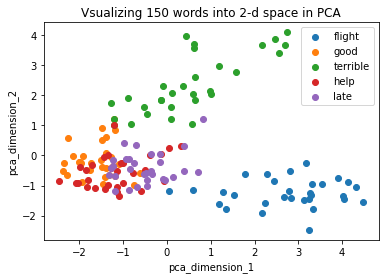

In [19]:
x = 0
while x <= pca_df.shape[0]:
    plt.scatter(pca_df[x:x+30]['col1'], pca_df[x:x+30]['col2'])
    plt.legend(labels = list_of_words)
    plt.xlabel('pca_dimension_1')
    plt.ylabel('pca_dimension_2')
    plt.title('Vsualizing 150 words into 2-d space in PCA')
    x += 30

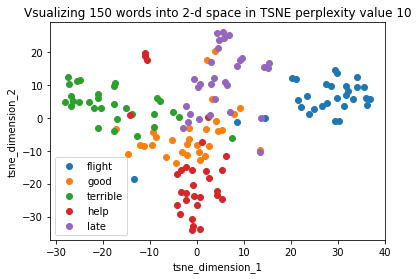

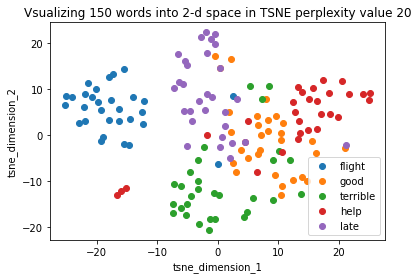

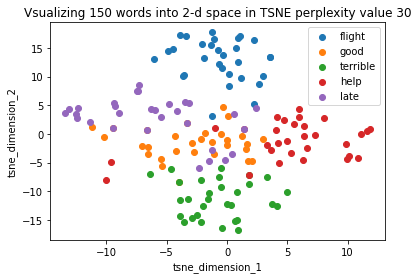

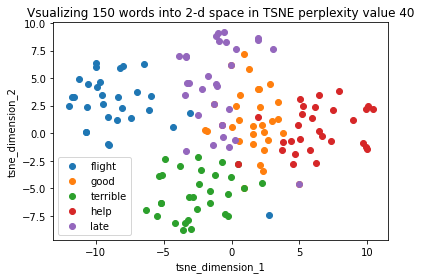

In [20]:
from sklearn.manifold import TSNE
for step in range(10, 50, 10):
    model_tsne = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=step).fit_transform(filtered_embeds)
    tsne_df = pd.DataFrame(data = model_tsne, columns = ['col1', 'col2'])
    plot_tsne(step)
    plt.show()

In [21]:
list_of_inertia = []
list_of_clusters = []
for cluster in range(2,20,1):
    kmeans = KMeans(n_clusters=cluster, random_state=0)
    kmeans.fit(filtered_embeds)
    model_kmeans = kmeans.transform(filtered_embeds)
    list_of_inertia.append(kmeans.inertia_)
    list_of_clusters.append(cluster)

Text(0.5, 1.0, 'Inertia Vs. K-values')

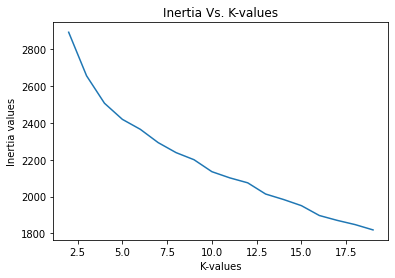

In [22]:
plt.plot(list_of_clusters, list_of_inertia)
plt.ylabel('Inertia values')
plt.xlabel('K-values')
plt.title('Inertia Vs. K-values')

In [23]:
from sklearn.metrics.cluster import normalized_mutual_info_score

In [24]:
from numpy import random

x=random.randint(150, size=(5))

In [25]:
xyz = [0,1,2,3,4]

In [26]:
true_labels = [27, 54, 87, 112, 145]

In [27]:
words = []
for value in true_labels:
    words.append(filtered_list[value])

In [28]:
kmeans_embeds = ge.embed_list(words)

In [29]:
# weights_of_words = np.asarray(weights_of_words)
# weights_of_words = weights_of_words.reshape(-1, 1)

In [30]:
new_array = []
x = 150
i = 0
while x >0:
    d = [i]* 30
    new_array+=d
    x -= 30
    i += 1

In [31]:
from sklearn.metrics.cluster import adjusted_rand_score
list_of_predictions = []
list_of_labels = []
cluster_centers = []
cluster_size = []
for cluster in range(2,20,1):
    kmeans = KMeans(n_clusters=cluster, random_state=0)
    kmeans.fit(filtered_embeds)
    model_kmeans = kmeans.transform(filtered_embeds)
    list_of_labels.append(kmeans.labels_)
    cluster_centers.append(kmeans.cluster_centers_)
   # kmeans_prediction = kmeans.predict(kmeans_embeds)
    kmeans_prediction = kmeans.predict(filtered_embeds)
    
    print('f cluster: {}'.format(cluster), normalized_mutual_info_score(new_array, kmeans_prediction))
    list_of_predictions.append(normalized_mutual_info_score(new_array, kmeans_prediction))
    cluster_size.append(cluster)

f cluster: 2 0.3601051520996533
f cluster: 3 0.6138981869527641
f cluster: 4 0.6410376946767983
f cluster: 5 0.7094382303217028
f cluster: 6 0.6292536722906626
f cluster: 7 0.682911927834081
f cluster: 8 0.6388489415826499
f cluster: 9 0.5783991425965873
f cluster: 10 0.559444573465042
f cluster: 11 0.5821611154070353
f cluster: 12 0.5688651317457399
f cluster: 13 0.6065932244105091
f cluster: 14 0.5624987464308063
f cluster: 15 0.6017181091613001
f cluster: 16 0.5382331889745171
f cluster: 17 0.5499027161807599
f cluster: 18 0.5152653171458719
f cluster: 19 0.5415851665019153


Text(0.5, 1.0, 'Graph of Mutual Information vs Clusters')

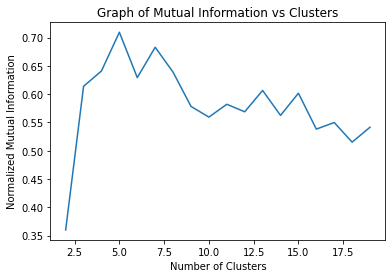

In [32]:
plt.plot( cluster_size, list_of_predictions)
plt.xlabel('Number of Clusters')
plt.ylabel('Normalized Mutual Information')
plt.title('Graph of Mutual Information vs Clusters')

In [33]:
list_of_predictions_adj = []
cluster_size_adj = []
for cluster in range(2,20,1):
    kmeans = KMeans(n_clusters=cluster, random_state=0)
    kmeans.fit(filtered_embeds)
    model_kmeans = kmeans.transform(filtered_embeds)
    list_of_labels.append(kmeans.labels_)
    cluster_centers.append(kmeans.cluster_centers_)
   # kmeans_prediction = kmeans.predict(kmeans_embeds)
    kmeans_prediction = kmeans.predict(filtered_embeds)
    
    print('f cluster: {}'.format(cluster), adjusted_rand_score(new_array, kmeans_prediction))
    list_of_predictions_adj.append(adjusted_rand_score(new_array, kmeans_prediction))
    cluster_size_adj.append(cluster)

f cluster: 2 0.1722357081181473
f cluster: 3 0.38110777201023993
f cluster: 4 0.4780653619861524
f cluster: 5 0.6068964244861813
f cluster: 6 0.4330101409403741
f cluster: 7 0.5970798321046645
f cluster: 8 0.47887643661249507
f cluster: 9 0.4068599112396771
f cluster: 10 0.360002445391908
f cluster: 11 0.37713513377800467
f cluster: 12 0.3823853849352148
f cluster: 13 0.3918508303299301
f cluster: 14 0.3009452245354132
f cluster: 15 0.4268139402018663
f cluster: 16 0.28672153347224927
f cluster: 17 0.30809463290644246
f cluster: 18 0.25395239051828045
f cluster: 19 0.25702441038004625


Text(0.5, 1.0, 'Graph of Mutual Information vs Clusters')

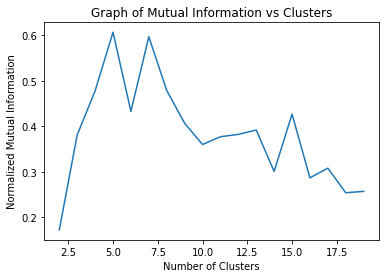

In [34]:
plt.plot( cluster_size_adj, list_of_predictions_adj)
plt.xlabel('Number of Clusters')
plt.ylabel('Normalized Mutual Information')
plt.title('Graph of Mutual Information vs Clusters')

In [35]:
from sklearn.metrics.cluster import contingency_matrix
list_of_predictions_purity = []
cluster_size_purity = []
for cluster in range(2,20,1):
    kmeans = KMeans(n_clusters=cluster, random_state=0)
    kmeans.fit(filtered_embeds)
    model_kmeans = kmeans.transform(filtered_embeds)
    list_of_labels.append(kmeans.labels_)
    cluster_centers.append(kmeans.cluster_centers_)
   # kmeans_prediction = kmeans.predict(kmeans_embeds)
    kmeans_prediction = kmeans.predict(filtered_embeds)
    cont_matrix = contingency_matrix(new_array, kmeans_prediction)
    purity = np.sum(np.amax(cont_matrix, axis=0)) / np.sum(cont_matrix)
    print('f cluster: {}'.format(cluster), purity)
    list_of_predictions_purity.append(purity)
    cluster_size_purity.append(cluster)

f cluster: 2 0.38666666666666666
f cluster: 3 0.5666666666666667
f cluster: 4 0.6933333333333334
f cluster: 5 0.8066666666666666
f cluster: 6 0.7533333333333333
f cluster: 7 0.8533333333333334
f cluster: 8 0.8266666666666667
f cluster: 9 0.7666666666666667
f cluster: 10 0.8066666666666666
f cluster: 11 0.76
f cluster: 12 0.7866666666666666
f cluster: 13 0.7866666666666666
f cluster: 14 0.7866666666666666
f cluster: 15 0.86
f cluster: 16 0.8
f cluster: 17 0.84
f cluster: 18 0.8066666666666666
f cluster: 19 0.8133333333333334


Text(0.5, 1.0, 'Graph of Purity vs Clusters')

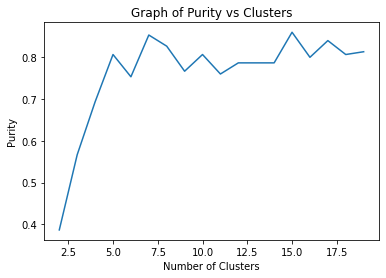

In [36]:
plt.plot(cluster_size_purity, list_of_predictions_purity)
plt.xlabel('Number of Clusters')
plt.ylabel('Purity')
plt.title('Graph of Purity vs Clusters')

In [37]:
print(embeds)

[[-1.6572e-01 -8.3950e-02  2.2570e-02  3.9720e-02  3.0814e-01  1.7639e-01
   2.8357e-01  5.5700e-03 -9.5600e-03  1.4846e-01  4.8067e-01  2.5237e-01
  -4.3009e-01  1.6862e-01  1.2911e-01 -5.9924e-01 -1.3999e-01  4.9635e-01
  -8.2510e-02 -2.6530e-01 -2.1277e-01 -2.2453e-01  3.0011e-01 -2.8075e-01
   5.1310e-02  1.0421e+00 -6.7080e-02 -5.7052e-01  8.7370e-02 -4.3915e-01
  -8.1000e-03  5.2400e-03  2.6832e-01 -6.5057e-01 -6.3500e-02  6.0998e-01
  -7.6290e-01  1.5033e-01  9.2465e-01  1.2769e-01 -3.1095e-01  2.4462e-01
   9.2752e-01 -9.8065e-01  3.0698e-01 -9.4610e-01 -1.6245e-01 -2.9793e-01
   4.7237e-01  3.2092e-01 -2.7117e-01 -4.8036e-01  1.8380e-02 -1.4158e-01
  -3.4337e-01  1.1486e-01  2.1472e-01  7.0729e-01 -2.4157e-01 -2.1553e-01
   3.9954e-01  4.6465e-01  4.1700e-01  2.0390e-01 -3.0071e-01  1.1968e-01
   2.6760e-01  1.3740e-02  3.3544e-01 -8.0908e-01 -1.9069e-01  2.4530e-01
  -5.8880e-02 -8.7979e-01  9.5020e-01 -1.7699e-01 -2.2566e-01  1.2184e-01
   5.2940e-01  1.7246e-01  9.9000e-03 

In [38]:
from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))
n_items = take(5, ge.embedding_dict.items())
for item in n_items:
    print(len(item[1]))

200
200
200
200
200


In [39]:
print(len(ge.embedding_dict.keys()))

12622


In [40]:
from nltk.stem import WordNetLemmatizer 
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from nltk.stem.snowball import SnowballStemmer

In [41]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return " ".join(lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text))
def stem_text(text):
    stemmer = SnowballStemmer("english")
    return stemmer.stem(text)

In [42]:
vocab = {}
ge = GloVe_Embedder("GloVe_Embedder_data.txt")
print(len(ge.embedding_dict.items()))
for word,emb in ge.embedding_dict.items():
#     vocab[word] = emb
    text = lemmatize_text(word)
    vocab[text] = emb
    text = stem_text(word)
    vocab[text] = emb
new_vocab = vocab
vocab = [(word,vocab[word]) for word in vocab]  

print(len(vocab))
print(vocab[50])

12622
14806
('1019', array([-0., -0.,  0.,  0., -0.,  0., -0.,  0., -0., -0.,  0.,  0., -0.,
       -0.,  0., -0.,  0., -0., -0., -0.,  0., -0.,  0.,  0., -0.,  0.,
        0., -0., -0., -0.,  0., -0., -0., -0.,  0., -0., -0., -0.,  0.,
        0.,  0., -0.,  0., -0.,  0., -0., -0., -0., -0.,  0., -0., -0.,
       -0., -0., -0., -0.,  0.,  0., -0.,  0.,  0.,  0.,  0., -0., -0.,
        0.,  0.,  0.,  0., -0., -0., -0.,  0.,  0., -0.,  0., -0.,  0.,
        0.,  0.,  0., -0.,  0.,  0.,  0., -0.,  0., -0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0., -0., -0., -0., -0.,  0.,  0., -0.,
       -0., -0., -0.,  0., -0.,  0., -0., -0., -0.,  0.,  0., -0., -0.,
       -0., -0.,  0., -0., -0.,  0., -0.,  0., -0., -0., -0.,  0.,  0.,
        0., -0., -0., -0.,  0., -0., -0., -0., -0., -0.,  0.,  0., -0.,
        0.,  0., -0.,  0.,  0., -0.,  0.,  0., -0., -0.,  0.,  0.,  0.,
        0., -0., -0.,  0., -0., -0.,  0.,  0.,  0.,  0., -0.,  0., -0.,
       -0.,  0., -0., -0.,  0.,  0., -0., -

In [43]:
with open("new_vocab.txt", "w") as f:
    for word,emb in new_vocab.items():
        string = word
        for num in emb:
            string = string+" "+str(num)
        f.write(f'{string}\n')

In [44]:
ge = GloVe_Embedder("new_vocab.txt")
list_of_words = ['flight', 'flight', 'terrible', 'help' , 'late']
word_weights = { x:list_of_words.count(x) for x in list_of_words}
print(word_weights)
a = ge.embed_list([w for w in word_weights])
print(a)
weights = [word_weights[w] for w in word_weights]
print(weights)
avg = np.average(a)
print(avg)

{'flight': 2, 'terrible': 1, 'help': 1, 'late': 1}
[[-5.7264e-01  3.5847e-01  3.7772e-01  1.7483e-01  4.2896e-01 -4.3311e-01
   2.5458e-01 -3.4977e-01 -8.4550e-02  2.8490e-01  3.3007e-01  5.1580e-02
  -1.2637e+00  1.5140e-02 -1.2770e-02 -7.4526e-01 -9.6853e-01  3.2440e-01
  -2.7002e-01 -2.7417e-01  6.2170e-02 -6.7265e-01  2.3016e-01 -2.7007e-01
   1.3676e-01  1.1842e+00  7.0742e-01 -5.4290e-01  2.3134e-01 -8.6747e-01
   5.0020e-02  2.3854e-01 -3.9610e-01 -5.7797e-01 -2.8019e-01  7.9970e-02
  -2.6871e-01  2.2040e-02  5.6883e-01 -3.5892e-01  2.1059e-01 -2.5440e-02
   6.6026e-01 -1.1235e+00 -2.2264e-01 -1.2676e+00 -1.0950e-01 -8.7628e-01
   1.9742e-01  2.3276e-01 -3.1823e-01 -6.1293e-01  3.6700e-01 -1.4953e-01
  -3.1428e-01  5.0690e-01  7.4110e-02  9.2500e-02 -6.2540e-01 -7.0250e-02
  -3.1023e-01  3.2032e-01  4.7524e-01  1.1826e-01 -3.9972e-01  5.7270e-02
   4.2885e-01  4.7902e-01  3.5050e-01 -6.2062e-01  8.3960e-02 -1.3004e-01
   4.6473e-01 -6.7550e-01  5.7303e-01  2.1650e-01 -7.9069e-01

In [45]:
# Loads a data file from a provided file location.
def load_data(path):
    try:
        loaded_data = pd.read_csv(path)
#         display(loaded_data)
    except:
        print('The required file does not exist!')    

    return loaded_data

In [46]:
train_data = load_data("IA3-train.csv")
val_data = load_data("IA3-dev.csv")

In [47]:
def preprocess_data(data):
    stopwords = set(nltk_stopwords.words('english'))
    def delete_symbols(text):
        text = text.lower()
        text = re.sub(r"what's", "what is ", text)
        text = re.sub(r"\'s", " ", text)
        text = re.sub(r"wa", " ", text)
        text = re.sub(r"co", " ", text)
        text = re.sub(r"http", " ", text)
        text = re.sub(r"thanks", "thank", text)
        text = re.sub(r"\'ve", " have ", text)
        text = re.sub(r"can't", "can not ", text)
        text = re.sub(r"n't", " not ", text)
        text = re.sub(r"i'm", "i am ", text)
        text = re.sub(r"\'re", " are ", text)
        text = re.sub(r"\'d", " would ", text)
        text = re.sub(r"\'ll", " will ", text)
    # Leave only letters and spaces
        text = re.sub(r'[^a-zA-Z ]', ' ', text)
    # Delete extra spaces
        text = ' '.join(text.split())
        return text
    

    data['delete_symbols'] = data['text'].map(lambda x: delete_symbols(x))
    
    def remove_stopwords(text):
        text =  ' '.join([word for word in text.split() if word not in stopwords])
        return text
    
#     data['remove_stopwords'] =data['delete_symbols'].apply(remove_stopwords)
    
    data['text_lemmatized'] = data['delete_symbols'].apply(lemmatize_text)

    data['new_col'] = data['text_lemmatized'].apply(stem_text)
#     data['new_col'] = data['text_lemmatized'].apply(lemma_of_the_text)
    return data

In [48]:
train_data = preprocess_data(train_data)
val_data = preprocess_data(val_data)

In [49]:
features_train = [word_tokenize(tweet) for tweet in train_data['new_col']]
target_train = train_data['sentiment']
features_val= [word_tokenize(tweet) for tweet in val_data['new_col']]
target_val = val_data['sentiment']

In [50]:
features_train

[['united',
  'who',
  'is',
  'in',
  'charge',
  'of',
  'making',
  'decision',
  'over',
  'there',
  'cancelled',
  'flightling',
  'flight',
  'ua',
  's',
  'unacceptable',
  'i',
  'should',
  'be',
  'in',
  'belize',
  'right',
  'now'],
 ['united',
  'great',
  'decision',
  'making',
  'skill',
  'flight',
  'ops',
  'iah',
  'bag',
  'make',
  'a',
  'minute',
  'nnection',
  'and',
  'i',
  'do',
  'not',
  'flight',
  'pushed',
  'early',
  'disappoint'],
 ['americanair',
  'so',
  'what',
  'if',
  'i',
  'did',
  'not',
  'have',
  'the',
  'fund',
  'to',
  'purchase',
  'another',
  'ticket',
  'your',
  'error',
  'would',
  'cause',
  'my',
  'family',
  'to',
  'miss',
  'the',
  'funer'],
 ['united',
  'my',
  'flying',
  'united',
  'is',
  'over',
  'sorry',
  'the',
  'captain',
  'still',
  'had',
  'minute',
  'of',
  'pre',
  'flight',
  'preparation',
  'to',
  'make',
  'while',
  'we',
  'sat',
  'with',
  'no',
  'air'],
 ['united',
  'i',
  'believe',


In [51]:
word_counts = {}
for item in features_train:
    for word in item:
        if not word in word_counts:
            word_counts[word] = 1
        else:
            word_counts[word] +=1

In [53]:
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf_positive = TfidfVectorizer(use_idf = True, lowercase = True).fit(train_data['new_col'])

In [54]:
bag_of_words = count_tf_idf_positive.transform(train_data['new_col'])
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in count_tf_idf_positive.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

In [55]:
words_freq = { w[0]:w[1] for w in words_freq}
print(words_freq)

{'to': 443.6377633961603, 'the': 381.1061685438686, 'you': 351.81314948419856, 'flight': 321.89229379410244, 'united': 308.8317060139, 'for': 293.59877179433437, 'not': 288.1416554458405, 'on': 279.36658151751055, 'usair': 273.34389171205686, 'and': 271.7932140847476, 'my': 260.6887283282811, 'thank': 255.74205433354447, 'americanair': 254.64734129165154, 'it': 244.50899062019374, 'is': 243.58939121718817, 'southwestair': 213.20085668899034, 'jetblue': 209.25165892956838, 'in': 208.35280996950962, 'have': 196.80469973999595, 'of': 182.36394270254556, 'me': 178.56808963576788, 'your': 171.74231779050496, 'that': 168.5692419175844, 'no': 163.55542638406612, 'are': 151.56507027510114, 'with': 148.1149863802058, 'at': 147.2522627186184, 'can': 146.7107859255876, 'hour': 145.43906395492192, 'get': 138.74765800820606, 'this': 138.31021060663872, 'we': 133.82695047764125, 'do': 133.76339995178657, 'but': 127.48510053089673, 'cancelled': 126.24094004323322, 'be': 124.33372267478285, 'am': 124.

In [56]:
def largest_matching_substrings(string,vocab,words):
    largest = ""
    for word in vocab:
        if word in string and len(word)>len(largest):
            largest = word
    if len(largest)>1:
        words.append(largest)
        string = string.replace(largest,"")
        largest_matching_substrings(string,vocab,words)
    else:
        return words
    return words

In [57]:
def average_embeddings(data,vocab,embedder):
    x = []
    wordList = [word[0] for word in vocab]
    emb = []
    sm = np.zeros((1,200))
    for i,tweet in enumerate(data):
        list_of_words = []
        for w in tweet:
            if w in wordList:
                list_of_words.append(w)
            else:
                merged_words = largest_matching_substrings(w,words_freq,[])
                if len(merged_words) >1:
                    emb = embedder.embed_list(merged_words)
                    for i,e in enumerate(emb):
                        sm = sm + e
                    sm = sm/len(merged_words)
                    
        list_of_words = [w for w in tweet if w in wordList]
        emb = embedder.embed_list(list_of_words)
               
        for i,e in enumerate(emb):
            sm = sm + e
        sm = (sm.flatten())/np.sum(len(list_of_words))
        x.append(sm)

    return np.array(x)   

In [58]:
x = average_embeddings(features_train,vocab,ge)

In [59]:
from scipy. sparse import csr_matrix
sparse_x = csr_matrix(x)

In [60]:
def score_c(scores,c_values):
    c_values.tolist()
    seaborn.set_style("whitegrid")
    figure = plot.figure()
    axe = figure.gca()
    line = plot.plot(c_values, scores, axes=axe)
    title = axe.set_title("Accuracy vs C")
    label = axe.set_ylabel("Accuracy")
    labels = axe.set_xlabel("C Value")
    axe.set_xscale('log')

In [61]:
from sklearn.svm import SVC
import math
from math import log
c_values = numpy.logspace(-4, 5, 100)
scores = []
best = 0
best_c = 0
for c_value in c_values:
    model_train = LinearSVC(random_state=12345, C = c_value)
    model_train.fit(sparse_x , target_train)
    score = model_train.score(X = sparse_x , y = target_train)
    if score > best:
        best = score
        best_c = c_value
    scores.append(score)
    print('c_value', c_value, 'score', score)
print('best', best, 'best_c', best_c)

c_value 0.0001 score 0.7985555555555556
c_value 0.0001232846739442066 score 0.8028888888888889
c_value 0.0001519911082952933 score 0.8098888888888889
c_value 0.0001873817422860383 score 0.8124444444444444
c_value 0.00023101297000831605 score 0.8166666666666667
c_value 0.0002848035868435802 score 0.8208888888888889
c_value 0.0003511191734215131 score 0.8247777777777778
c_value 0.0004328761281083057 score 0.8307777777777777
c_value 0.0005336699231206312 score 0.8366666666666667
c_value 0.0006579332246575682 score 0.8435555555555555
c_value 0.0008111308307896872 score 0.8477777777777777
c_value 0.001 score 0.8527777777777777
c_value 0.0012328467394420659 score 0.8595555555555555
c_value 0.0015199110829529332 score 0.8654444444444445
c_value 0.001873817422860383 score 0.872
c_value 0.0023101297000831605 score 0.8772222222222222
c_value 0.002848035868435802 score 0.8826666666666667
c_value 0.003511191734215131 score 0.8867777777777778
c_value 0.004328761281083062 score 0.8918888888888888
c_

c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1.0 score 0.9214444444444444


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1.232846739442066 score 0.9217777777777778


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1.5199110829529332 score 0.9217777777777778


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1.873817422860383 score 0.9214444444444444


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 2.310129700083158 score 0.9214444444444444


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 2.848035868435805 score 0.9214444444444444


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 3.5111917342151346 score 0.9215555555555556


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 4.328761281083062 score 0.9215555555555556


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 5.336699231206313 score 0.9217777777777778


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 6.5793322465756825 score 0.921


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 8.111308307896872 score 0.9213333333333333


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 10.0 score 0.9218888888888889


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 12.32846739442066 score 0.9201111111111111


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 15.199110829529332 score 0.9207777777777778


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 18.73817422860383 score 0.9148888888888889


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 23.10129700083163 score 0.9196666666666666


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 28.48035868435805 score 0.9186666666666666


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 35.111917342151344 score 0.9176666666666666


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 43.287612810830616 score 0.9201111111111111


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 53.366992312063125 score 0.919


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 65.79332246575683 score 0.8875555555555555


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 81.11308307896873 score 0.9162222222222223


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 100.0 score 0.918


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 123.28467394420659 score 0.9163333333333333


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 151.99110829529332 score 0.8912222222222222


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 187.3817422860383 score 0.9178888888888889


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 231.01297000831627 score 0.9188888888888889


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 284.8035868435805 score 0.9151111111111111


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 351.11917342151344 score 0.9194444444444444


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 432.87612810830615 score 0.9101111111111111


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 533.6699231206312 score 0.7701111111111111


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 657.9332246575682 score 0.9148888888888889


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 811.1308307896873 score 0.9181111111111111


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1000.0 score 0.9125555555555556


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1232.8467394420659 score 0.9176666666666666


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1519.9110829529332 score 0.9135555555555556


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1873.8174228603868 score 0.9103333333333333


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 2310.129700083163 score 0.9104444444444444


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 2848.035868435805 score 0.7941111111111111


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 3511.1917342151346 score 0.9167777777777778


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 4328.7612810830615 score 0.42488888888888887


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 5336.699231206313 score 0.879


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 6579.332246575683 score 0.9195555555555556


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 8111.308307896872 score 0.9133333333333333


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 10000.0 score 0.908


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 12328.467394420684 score 0.8892222222222222


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 15199.11082952933 score 0.8892222222222222


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 18738.174228603868 score 0.8892222222222222


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 23101.29700083158 score 0.9102222222222223


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 28480.35868435805 score 0.9116666666666666


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 35111.917342151275 score 0.9116666666666666


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 43287.612810830615 score 0.9122222222222223


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 53366.99231206302 score 0.8938888888888888


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 65793.32246575682 score 0.9027777777777778


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 81113.08307896889 score 0.9027777777777778
c_value 100000.0 score 0.9195555555555556
best 0.9218888888888889 best_c 10.0


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


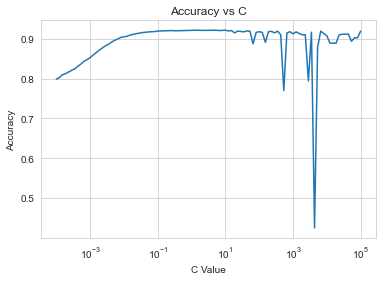

In [62]:
score_c(scores,c_values)

In [63]:
x_val  = average_embeddings(features_val,vocab,ge)
sparse_x_val = csr_matrix(x_val)

In [64]:
c_values = numpy.logspace(-4, 4, 100)
scores = []
best = 0
best_c = 0
for c_value in c_values:
    model_valid = LinearSVC(random_state=12345, C = c_value)
    model_valid.fit(sparse_x, target_train)
    score_val = model_valid.score(X = sparse_x_val, y = target_val)
    if score_val > best:
        best = score_val
        best_c = c_value
    scores.append(score_val)
    print('c_value', c_value, 'score', score_val)
print('best', best, 'best_c', best_c)  

c_value 0.0001 score 0.792
c_value 0.00012045035402587823 score 0.8008
c_value 0.000145082877849594 score 0.804
c_value 0.0001747528400007683 score 0.808
c_value 0.00021049041445120198 score 0.8104
c_value 0.00025353644939701115 score 0.8144
c_value 0.0003053855508833416 score 0.8184
c_value 0.0003678379771828634 score 0.8252
c_value 0.0004430621457583882 score 0.83
c_value 0.0005336699231206312 score 0.8344
c_value 0.0006428073117284319 score 0.8368
c_value 0.000774263682681127 score 0.8416
c_value 0.0009326033468832199 score 0.844
c_value 0.0011233240329780276 score 0.8492
c_value 0.0013530477745798076 score 0.854
c_value 0.0016297508346206436 score 0.8596
c_value 0.0019630406500402726 score 0.8668
c_value 0.002364489412645407 score 0.8752
c_value 0.002848035868435802 score 0.88
c_value 0.003430469286314919 score 0.8848
c_value 0.0041320124001153384 score 0.89
c_value 0.004977023564332114 score 0.8952
c_value 0.005994842503189409 score 0.8976
c_value 0.007220809018385471 score 0.9008

c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1.3219411484660315 score 0.9184


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1.592282793341094 score 0.9176


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1.9179102616724888 score 0.918


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 2.310129700083163 score 0.9184


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 2.782559402207126 score 0.9188


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 3.351602650938848 score 0.9188


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 4.037017258596558 score 0.9188


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 4.862601580065354 score 0.9192


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 5.857020818056673 score 0.918


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 7.054802310718645 score 0.918


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 8.497534359086455 score 0.9188


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 10.235310218990268 score 0.9176


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 12.328467394420684 score 0.9172


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 14.849682622544666 score 0.9156


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 17.886495290574352 score 0.91


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 21.544346900318867 score 0.918


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 25.950242113997373 score 0.9184


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 31.257158496882415 score 0.9144


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 37.649358067924716 score 0.9


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 45.34878508128591 score 0.9148


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 54.62277217684348 score 0.91


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 65.79332246575683 score 0.8848


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 79.24828983539186 score 0.9156


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 95.45484566618347 score 0.9104


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 114.9756995397738 score 0.9056


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 138.48863713938746 score 0.9048


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 166.81005372000593 score 0.9128


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 200.923300256505 score 0.9152


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 242.01282647943833 score 0.9152


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 291.5053062825182 score 0.6772


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 351.11917342151344 score 0.9156


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 422.9242874389508 score 0.8824


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 509.4138014816386 score 0.9136


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 613.5907273413176 score 0.9076


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 739.072203352579 score 0.7736


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 890.2150854450392 score 0.9116


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1072.2672220103254 score 0.88


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1291.5496650148852 score 0.9124


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1555.6761439304755 score 0.9144


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1873.8174228603868 score 0.906


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 2257.0197196339213 score 0.9028


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 2718.5882427329457 score 0.92


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 3274.5491628777318 score 0.9156


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 3944.206059437664 score 0.4284


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 4750.810162102803 score 0.9064


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 5722.3676593502205 score 0.9172


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 6892.61210434971 score 0.896


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 8302.175681319752 score 0.908
c_value 10000.0 score 0.9084
best 0.92 best_c 2718.5882427329457


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


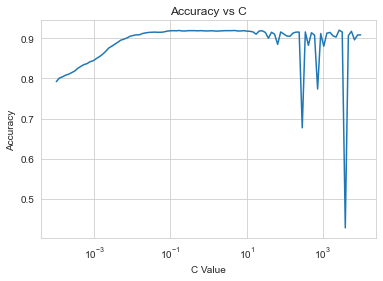

In [65]:
score_c(scores,c_values)

In [66]:
def weighted_average_embeddings(data,vocab,embedder,weights):
    x = []
    wordList = [word[0] for word in vocab]
    emb = []
    sm = np.zeros((1,200))
    for i,tweet in enumerate(data):
        list_of_words = []
        for w in tweet:
            if w in wordList:
                list_of_words.append(w)
            else:
                merged_words = largest_matching_substrings(w,words_freq,[])
                if len(merged_words) >1:
                    emb = embedder.embed_list(merged_words)
                    word_weights = [weights[w] for w in merged_words]
                    for i,e in enumerate(emb):
                        sm = sm + e * word_weights[i]
                    sm = sm/np.sum(word_weights)
                    
        list_of_words = [w for w in tweet if w in wordList and w in weights]
        word_weights = [weights[w] for w in list_of_words]
        emb = embedder.embed_list(list_of_words)
               
        for i,e in enumerate(emb):
            sm = sm + e * word_weights[i]
        sm = (sm.flatten())/np.sum(word_weights)
        x.append(sm)

    return np.array(x)   

In [67]:
x = weighted_average_embeddings(features_train,vocab,ge,words_freq)

In [68]:
sparse_x = csr_matrix(x)

In [69]:
c_values = numpy.logspace(-4, 5, 100)
scores = []
best = 0
best_c = 0
for c_value in c_values:
    model_train = LinearSVC(random_state=12345, C = c_value)
    model_train.fit(sparse_x , target_train)
    score = model_train.score(X = sparse_x , y = target_train)
    if score > best:
        best = score
        best_c = c_value
    scores.append(score)
    print('c_value', c_value, 'score', score)
print('best', best, 'best_c', best_c)

c_value 0.0001 score 0.805
c_value 0.0001232846739442066 score 0.8137777777777778
c_value 0.0001519911082952933 score 0.8178888888888889
c_value 0.0001873817422860383 score 0.821
c_value 0.00023101297000831605 score 0.8242222222222222
c_value 0.0002848035868435802 score 0.8274444444444444
c_value 0.0003511191734215131 score 0.8323333333333334
c_value 0.0004328761281083057 score 0.8366666666666667
c_value 0.0005336699231206312 score 0.8385555555555556
c_value 0.0006579332246575682 score 0.8411111111111111
c_value 0.0008111308307896872 score 0.8437777777777777
c_value 0.001 score 0.8475555555555555
c_value 0.0012328467394420659 score 0.85
c_value 0.0015199110829529332 score 0.853
c_value 0.001873817422860383 score 0.8562222222222222
c_value 0.0023101297000831605 score 0.8587777777777778
c_value 0.002848035868435802 score 0.8616666666666667
c_value 0.003511191734215131 score 0.8642222222222222
c_value 0.004328761281083062 score 0.8658888888888889
c_value 0.005336699231206312 score 0.86755

c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1.0 score 0.9011111111111111


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1.232846739442066 score 0.9012222222222223


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1.5199110829529332 score 0.902


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1.873817422860383 score 0.9026666666666666


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 2.310129700083158 score 0.9028888888888889


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 2.848035868435805 score 0.9036666666666666


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 3.5111917342151346 score 0.9035555555555556


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 4.328761281083062 score 0.9052222222222223


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 5.336699231206313 score 0.9054444444444445


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 6.5793322465756825 score 0.9053333333333333


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 8.111308307896872 score 0.9022222222222223


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 10.0 score 0.9027777777777778


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 12.32846739442066 score 0.9087777777777778


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 15.199110829529332 score 0.9088888888888889


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 18.73817422860383 score 0.8985555555555556


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 23.10129700083163 score 0.8938888888888888


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 28.48035868435805 score 0.906


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 35.111917342151344 score 0.902


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 43.287612810830616 score 0.8924444444444445


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 53.366992312063125 score 0.9085555555555556


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 65.79332246575683 score 0.8771111111111111


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 81.11308307896873 score 0.9051111111111111


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 100.0 score 0.9045555555555556


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 123.28467394420659 score 0.8937777777777778


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 151.99110829529332 score 0.6782222222222222


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 187.3817422860383 score 0.8953333333333333


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 231.01297000831627 score 0.7907777777777778


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 284.8035868435805 score 0.8364444444444444


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 351.11917342151344 score 0.8092222222222222


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 432.87612810830615 score 0.8976666666666666


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 533.6699231206312 score 0.8746666666666667


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 657.9332246575682 score 0.7633333333333333


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 811.1308307896873 score 0.8957777777777778


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1000.0 score 0.843


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1232.8467394420659 score 0.8946666666666667


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1519.9110829529332 score 0.8433333333333334


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1873.8174228603868 score 0.47588888888888886


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 2310.129700083163 score 0.8727777777777778


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 2848.035868435805 score 0.8962222222222223


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 3511.1917342151346 score 0.8706666666666667


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 4328.7612810830615 score 0.8915555555555555


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 5336.699231206313 score 0.8972222222222223


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 6579.332246575683 score 0.8741111111111111


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 8111.308307896872 score 0.722


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 10000.0 score 0.8876666666666667


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 12328.467394420684 score 0.8765555555555555


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 15199.11082952933 score 0.8914444444444445


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 18738.174228603868 score 0.8894444444444445


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 23101.29700083158 score 0.3748888888888889


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 28480.35868435805 score 0.8772222222222222


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 35111.917342151275 score 0.8838888888888888


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 43287.612810830615 score 0.8353333333333334


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 53366.99231206302 score 0.8986666666666666


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 65793.32246575682 score 0.8924444444444445


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 81113.08307896889 score 0.8728888888888889
c_value 100000.0 score 0.8758888888888889
best 0.9088888888888889 best_c 15.199110829529332


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


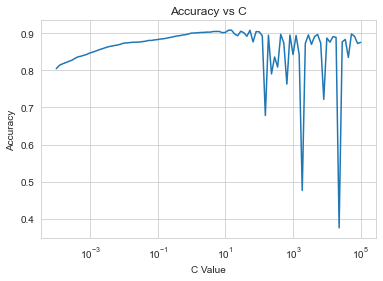

In [70]:
score_c(scores,c_values)

In [71]:
x_val  = weighted_average_embeddings(features_val,vocab,ge,words_freq)
sparse_x_val = csr_matrix(x_val)

In [72]:
c_values = numpy.logspace(-4, 4, 100)
scores = []
best = 0
best_c = 0
for c_value in c_values:
    model_valid = LinearSVC(random_state=12345, C = c_value)
    model_valid.fit(sparse_x, target_train)
    score_val = model_valid.score(X = sparse_x_val, y = target_val)
    if score_val > best:
        best = score_val
        best_c = c_value
    scores.append(score_val)
    print('c_value', c_value, 'score', score_val)
print('best', best, 'best_c', best_c)  

c_value 0.0001 score 0.8044
c_value 0.00012045035402587823 score 0.8124
c_value 0.000145082877849594 score 0.816
c_value 0.0001747528400007683 score 0.8172
c_value 0.00021049041445120198 score 0.8216
c_value 0.00025353644939701115 score 0.8244
c_value 0.0003053855508833416 score 0.8268
c_value 0.0003678379771828634 score 0.8324
c_value 0.0004430621457583882 score 0.8356
c_value 0.0005336699231206312 score 0.8368
c_value 0.0006428073117284319 score 0.8408
c_value 0.000774263682681127 score 0.8408
c_value 0.0009326033468832199 score 0.8444
c_value 0.0011233240329780276 score 0.8452
c_value 0.0013530477745798076 score 0.8496
c_value 0.0016297508346206436 score 0.8516
c_value 0.0019630406500402726 score 0.8564
c_value 0.002364489412645407 score 0.856
c_value 0.002848035868435802 score 0.858
c_value 0.003430469286314919 score 0.858
c_value 0.0041320124001153384 score 0.8604
c_value 0.004977023564332114 score 0.8608
c_value 0.005994842503189409 score 0.8608
c_value 0.007220809018385471 score

c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1.0974987654930568 score 0.8968


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1.3219411484660315 score 0.8972


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1.592282793341094 score 0.898


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1.9179102616724888 score 0.8988


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 2.310129700083163 score 0.8988


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 2.782559402207126 score 0.8996


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 3.351602650938848 score 0.9


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 4.037017258596558 score 0.9


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 4.862601580065354 score 0.8996


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 5.857020818056673 score 0.8996


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 7.054802310718645 score 0.8904


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 8.497534359086455 score 0.902


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 10.235310218990268 score 0.9048


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 12.328467394420684 score 0.9028


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 14.849682622544666 score 0.8984


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 17.886495290574352 score 0.904


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 21.544346900318867 score 0.8992


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 25.950242113997373 score 0.9036


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 31.257158496882415 score 0.8964


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 37.649358067924716 score 0.9012


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 45.34878508128591 score 0.8944


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 54.62277217684348 score 0.5808


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 65.79332246575683 score 0.8644


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 79.24828983539186 score 0.8988


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 95.45484566618347 score 0.5476


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 114.9756995397738 score 0.8772


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 138.48863713938746 score 0.6664


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 166.81005372000593 score 0.8872


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 200.923300256505 score 0.8616


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 242.01282647943833 score 0.8688


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 291.5053062825182 score 0.886


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 351.11917342151344 score 0.8032


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 422.9242874389508 score 0.8912


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 509.4138014816386 score 0.8692


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 613.5907273413176 score 0.8848


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 739.072203352579 score 0.8548


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 890.2150854450392 score 0.8692


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1072.2672220103254 score 0.8644


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1291.5496650148852 score 0.88


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1555.6761439304755 score 0.874


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1873.8174228603868 score 0.4716


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 2257.0197196339213 score 0.8172


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 2718.5882427329457 score 0.8556


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 3274.5491628777318 score 0.5236


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 3944.206059437664 score 0.866


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 4750.810162102803 score 0.7916


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 5722.3676593502205 score 0.8908


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 6892.61210434971 score 0.876


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 8302.175681319752 score 0.8808
c_value 10000.0 score 0.8728
best 0.9048 best_c 10.235310218990268


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


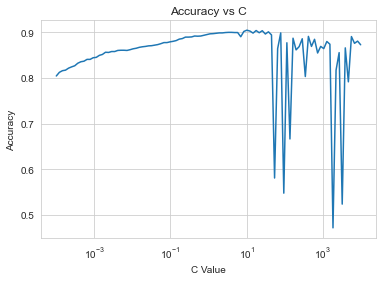

In [73]:
score_c(scores,c_values)

In [74]:
def pca_embeddings(data,vocab,embedder):
    x = []
    wordList = [word[0] for word in vocab]
    sm = np.zeros((1,200))
    for i,tweet in enumerate(data):
        emb = []
        list_of_words = []
        for w in tweet:
            if w in wordList:
                list_of_words.append(w)
            else:
                merged_words = largest_matching_substrings(w,words_freq,[])
                
        list_of_words = [w for w in tweet if w in wordList] + merged_words
        emb = embedder.embed_list(list_of_words)
        pca = PCA(n_components=1)
        model_pca = pca.fit_transform(emb.T).flatten()
        
        x.append(model_pca)

    return np.array(x)   

In [75]:
x = pca_embeddings(features_train,vocab,ge)

c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_pca.py:527: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_pca.py:527: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_pca.py:527: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_pca.py:527: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_p

In [76]:
sparse_x = csr_matrix(x)

In [77]:
c_values = numpy.logspace(-4, 5, 100)
scores = []
best = 0
best_c = 0
for c_value in c_values:
    model_train = LinearSVC(random_state=12345, C = c_value)
    model_train.fit(sparse_x , target_train)
    score = model_train.score(X = sparse_x , y = target_train)
    if score > best:
        best = score
        best_c = c_value
    scores.append(score)
    print('c_value', c_value, 'score', score)
print('best', best, 'best_c', best_c)

c_value 0.0001 score 0.8634444444444445
c_value 0.0001232846739442066 score 0.8688888888888889
c_value 0.0001519911082952933 score 0.8731111111111111
c_value 0.0001873817422860383 score 0.8786666666666667
c_value 0.00023101297000831605 score 0.8827777777777778
c_value 0.0002848035868435802 score 0.887
c_value 0.0003511191734215131 score 0.8902222222222222
c_value 0.0004328761281083057 score 0.8931111111111111
c_value 0.0005336699231206312 score 0.8962222222222223
c_value 0.0006579332246575682 score 0.8995555555555556
c_value 0.0008111308307896872 score 0.9021111111111111
c_value 0.001 score 0.9027777777777778
c_value 0.0012328467394420659 score 0.9051111111111111
c_value 0.0015199110829529332 score 0.906
c_value 0.001873817422860383 score 0.9087777777777778
c_value 0.0023101297000831605 score 0.9103333333333333
c_value 0.002848035868435802 score 0.9122222222222223
c_value 0.003511191734215131 score 0.9132222222222223
c_value 0.004328761281083062 score 0.9136666666666666
c_value 0.00533

c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 0.06579332246575682 score 0.9166666666666666


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 0.08111308307896872 score 0.9162222222222223


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 0.1 score 0.9163333333333333


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 0.12328467394420659 score 0.9163333333333333


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 0.15199110829529347 score 0.9162222222222223


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 0.1873817422860385 score 0.9161111111111111


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 0.23101297000831605 score 0.9165555555555556


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 0.2848035868435802 score 0.9163333333333333


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 0.3511191734215131 score 0.918


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 0.43287612810830617 score 0.9171111111111111


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 0.5336699231206312 score 0.9162222222222223


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 0.6579332246575682 score 0.917


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 0.8111308307896873 score 0.916


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1.0 score 0.9168888888888889


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1.232846739442066 score 0.9122222222222223


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1.5199110829529332 score 0.9178888888888889


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1.873817422860383 score 0.9164444444444444


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 2.310129700083158 score 0.915


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 2.848035868435805 score 0.9143333333333333


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 3.5111917342151346 score 0.9136666666666666


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 4.328761281083062 score 0.8763333333333333


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 5.336699231206313 score 0.8694444444444445


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 6.5793322465756825 score 0.911


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 8.111308307896872 score 0.9086666666666666


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 10.0 score 0.859


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 12.32846739442066 score 0.8502222222222222


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 15.199110829529332 score 0.9057777777777778


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 18.73817422860383 score 0.913


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 23.10129700083163 score 0.8765555555555555


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 28.48035868435805 score 0.9056666666666666


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 35.111917342151344 score 0.9117777777777778


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 43.287612810830616 score 0.9068888888888889


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 53.366992312063125 score 0.9113333333333333


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 65.79332246575683 score 0.9047777777777778


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 81.11308307896873 score 0.9126666666666666


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 100.0 score 0.8954444444444445


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 123.28467394420659 score 0.8938888888888888


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 151.99110829529332 score 0.7435555555555555


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 187.3817422860383 score 0.6075555555555555


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 231.01297000831627 score 0.9052222222222223


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 284.8035868435805 score 0.8714444444444445


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 351.11917342151344 score 0.8998888888888888


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 432.87612810830615 score 0.8752222222222222


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 533.6699231206312 score 0.6412222222222222


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 657.9332246575682 score 0.8402222222222222


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 811.1308307896873 score 0.6087777777777778


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1000.0 score 0.9022222222222223


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1232.8467394420659 score 0.906


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1519.9110829529332 score 0.8978888888888888


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1873.8174228603868 score 0.8904444444444445


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 2310.129700083163 score 0.8688888888888889


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 2848.035868435805 score 0.8713333333333333


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 3511.1917342151346 score 0.9042222222222223


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 4328.7612810830615 score 0.8982222222222223


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 5336.699231206313 score 0.8826666666666667


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 6579.332246575683 score 0.8688888888888889


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 8111.308307896872 score 0.8478888888888889


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 10000.0 score 0.9031111111111111


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 12328.467394420684 score 0.8862222222222222


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 15199.11082952933 score 0.8994444444444445


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 18738.174228603868 score 0.907


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 23101.29700083158 score 0.9023333333333333


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 28480.35868435805 score 0.8777777777777778


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 35111.917342151275 score 0.8886666666666667


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 43287.612810830615 score 0.9061111111111111


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 53366.99231206302 score 0.7822222222222223


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 65793.32246575682 score 0.8992222222222223


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 81113.08307896889 score 0.8152222222222222
c_value 100000.0 score 0.9028888888888889
best 0.918 best_c 0.3511191734215131


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


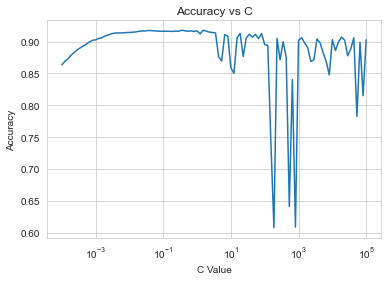

In [78]:
score_c(scores,c_values)

In [79]:
x_val  = pca_embeddings(features_val,vocab,ge)
sparse_x_val = csr_matrix(x_val)

c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_pca.py:527: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


In [80]:
c_values = numpy.logspace(-4, 4, 100)
scores = []
best = 0
best_c = 0
for c_value in c_values:
    model_valid = LinearSVC(random_state=12345, C = c_value)
    model_valid.fit(sparse_x, target_train)
    score_val = model_valid.score(X = sparse_x_val, y = target_val)
    if score_val > best:
        best = score_val
        best_c = c_value
    scores.append(score_val)
    print('c_value', c_value, 'score', score_val)
print('best', best, 'best_c', best_c)  

c_value 0.0001 score 0.8556
c_value 0.00012045035402587823 score 0.8612
c_value 0.000145082877849594 score 0.8664
c_value 0.0001747528400007683 score 0.8704
c_value 0.00021049041445120198 score 0.8776
c_value 0.00025353644939701115 score 0.8812
c_value 0.0003053855508833416 score 0.8856
c_value 0.0003678379771828634 score 0.8868
c_value 0.0004430621457583882 score 0.8888
c_value 0.0005336699231206312 score 0.8924
c_value 0.0006428073117284319 score 0.8944
c_value 0.000774263682681127 score 0.8964
c_value 0.0009326033468832199 score 0.8984
c_value 0.0011233240329780276 score 0.9004
c_value 0.0013530477745798076 score 0.9024
c_value 0.0016297508346206436 score 0.9044
c_value 0.0019630406500402726 score 0.9068
c_value 0.002364489412645407 score 0.908
c_value 0.002848035868435802 score 0.91
c_value 0.003430469286314919 score 0.9112
c_value 0.0041320124001153384 score 0.912
c_value 0.004977023564332114 score 0.9144
c_value 0.005994842503189409 score 0.9156
c_value 0.007220809018385471 score

c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 0.06734150657750829 score 0.92


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 0.08111308307896872 score 0.9196


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 0.09770099572992257 score 0.92


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 0.1176811952434999 score 0.9204


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 0.14174741629268062 score 0.9204


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 0.1707352647470692 score 0.9196


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 0.20565123083486536 score 0.9204


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 0.24770763559917114 score 0.9204


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 0.298364724028334 score 0.9208


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 0.3593813663804629 score 0.9204


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 0.43287612810830617 score 0.9208


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 0.521400828799969 score 0.9152


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 0.6280291441834259 score 0.9172


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 0.7564633275546291 score 0.9192


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 0.9111627561154896 score 0.9236


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1.0974987654930568 score 0.9068


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1.3219411484660315 score 0.9172


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1.592282793341094 score 0.9176


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1.9179102616724888 score 0.9144


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 2.310129700083163 score 0.9116


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 2.782559402207126 score 0.9112


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 3.351602650938848 score 0.9164


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 4.037017258596558 score 0.8836


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 4.862601580065354 score 0.9092


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 5.857020818056673 score 0.9108


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 7.054802310718645 score 0.8024


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 8.497534359086455 score 0.8604


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 10.235310218990268 score 0.8988


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 12.328467394420684 score 0.852


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 14.849682622544666 score 0.814


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 17.886495290574352 score 0.9052


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 21.544346900318867 score 0.9124


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 25.950242113997373 score 0.8792


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 31.257158496882415 score 0.8752


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 37.649358067924716 score 0.828


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 45.34878508128591 score 0.8996


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 54.62277217684348 score 0.8


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 65.79332246575683 score 0.8956


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 79.24828983539186 score 0.8956


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 95.45484566618347 score 0.786


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 114.9756995397738 score 0.8512


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 138.48863713938746 score 0.906


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 166.81005372000593 score 0.91


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 200.923300256505 score 0.892


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 242.01282647943833 score 0.8744


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 291.5053062825182 score 0.9028


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 351.11917342151344 score 0.8964


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 422.9242874389508 score 0.8924


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 509.4138014816386 score 0.9012


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 613.5907273413176 score 0.8628


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 739.072203352579 score 0.8992


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 890.2150854450392 score 0.8896


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1072.2672220103254 score 0.8908


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1291.5496650148852 score 0.8936


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1555.6761439304755 score 0.8756


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 1873.8174228603868 score 0.8808


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 2257.0197196339213 score 0.886


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 2718.5882427329457 score 0.8824


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 3274.5491628777318 score 0.8908


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 3944.206059437664 score 0.8908


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 4750.810162102803 score 0.9028


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 5722.3676593502205 score 0.8936


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 6892.61210434971 score 0.4424


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


c_value 8302.175681319752 score 0.658
c_value 10000.0 score 0.8856
best 0.9236 best_c 0.9111627561154896


c:\users\ahsun\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


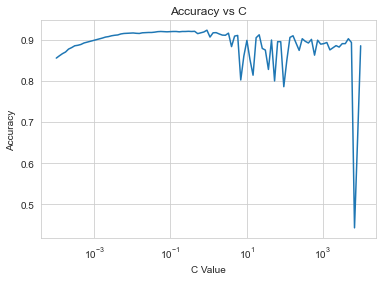

In [81]:
score_c(scores,c_values)